In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from scipy.stats import skew, kurtosis

torch.cuda.empty_cache()
# imports of custom blocks for model, data generation
from Ferret.ImplicitAm import ImplicitAmBre, ImplicitAmBer
from models import *
from create_plots import *
from utils import AmericanPutData, get_prices_put
from utils import S, T, K, RISK_FREE, SIGMA, S_MAX

## Put Option

### Content: 
1. **Generating Data**
2. **Training on Generated Data, Testing Both on Generated and Real Data**
3. **Training on Real Data, Testing on Real Data**
4. **Mixture of Data (70/30, 50/50), Testing on Real Data**


In [2]:
put_data = AmericanPutData(t_range=T, S_range=S, K=K, r=RISK_FREE, sigma=SIGMA)
# N_ivp - IVP points
# N_bvp - both BVP1 and BVP2 points
# N_col - colocation points
X = put_data.initialize_data(N_ivp=1000, N_bvp=3000, N_col=6000, is_call=False)
option = ImplicitAmBer(
    S[0],
    K,
    RISK_FREE,
    T[1],
    SIGMA,
    S_MAX,
    M=400,  # S
    N=365 * 3,  # t
    is_call=False,
)
option.price()
option_fde_prices = option.grid
data = get_prices_put(X, option_fde_prices, generated=True)
df = pd.DataFrame(
    data=data,
    columns=[
        "TimeToExp",
        "UnderlyingPrice",
        "TargetPrice",
        "OpenInterest",
        "Delta",
        "Gamma",
        "Theta",
        "Vega",
        "BSAprox",
    ],
)
df[["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]] = df[
    ["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]
].round(2)
df["OpenInterest"] = df["OpenInterest"].round(0)
df.to_csv("../train_data/generated_put.csv")

(10000, 8)


In [2]:
df = pd.read_csv("../train_data/generated_put.csv", index_col=0)
df.head()

,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
0,827.0,138.66,39.12,133.0,-0.876502,0.052474,-4.578248,15.334991,0.00
1,1045.0,113.58,45.38,228.0,-0.118852,0.002001,-7.851140,3.742773,6.48
2,395.0,194.28,27.86,937.0,-0.756109,0.000596,-1.044538,0.431675,0.00
3,563.0,112.40,45.66,109.0,-0.196355,0.012452,-4.211471,12.599267,7.64
4,980.0,145.38,37.53,72.0,-0.417402,0.012488,-0.112282,7.536177,0.00


In [4]:
# Check for ITM and OTM
print(f"ITM count:{np.sum(df.UnderlyingPrice < K)}")
print(f"OTM count:{np.sum(df.UnderlyingPrice >= K)}")

ITM count:4272
OTM count:5728


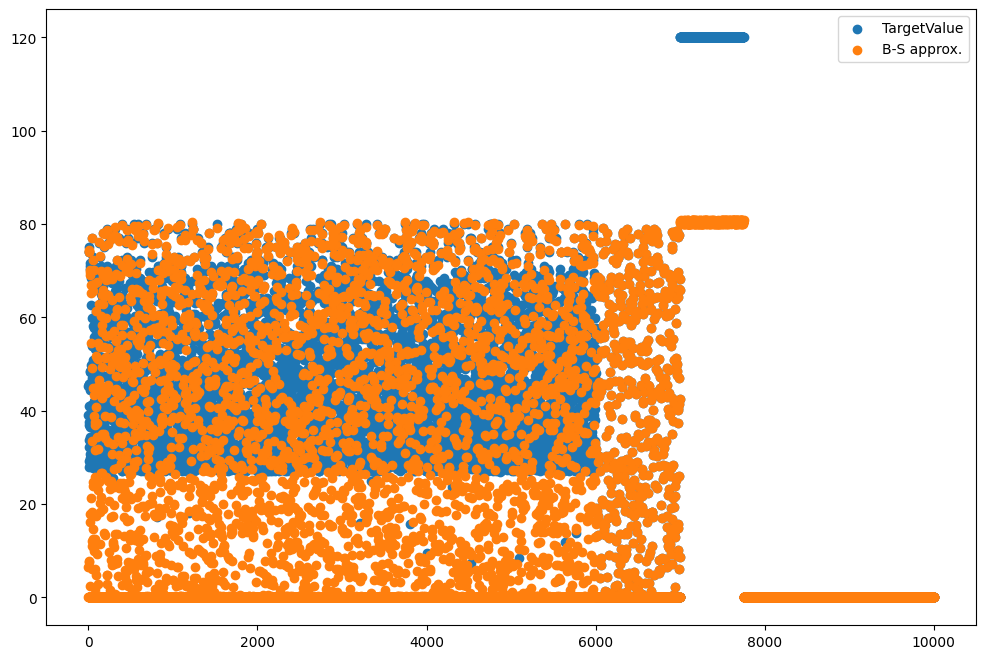

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(
    x=np.arange(1, len(df.TargetPrice) + 1, 1), y=df.TargetPrice, label="TargetValue"
)
plt.scatter(x=np.arange(1, len(df.BSAprox) + 1, 1), y=df.BSAprox, label="B-S approx.")
plt.legend()
plt.show()

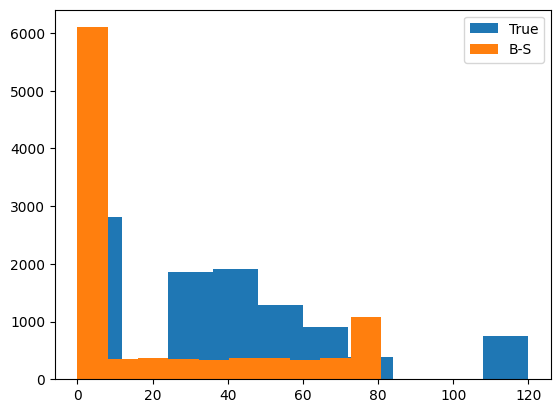

In [6]:
plt.hist(df.TargetPrice, label="True")
plt.hist(df.BSAprox, label="B-S")
plt.legend()
plt.show()

In [4]:
# # adding BSAprox column to real data
# # Run it once, only if u dont have saved df
# df_real = pd.read_csv("../train_data/put_df.csv", index_col=0)
# df_real = get_prices_put(df_real.to_numpy(), generated=False)
# df_real = pd.DataFrame(
#     data=df_real,
#     columns=[
#         [
#             "UnderlyingPrice",
#             "Type",
#             "Strike",
#             "OpenInterest",
#             "IV",
#             "Delta",
#             "Gamma",
#             "Theta",
#             "Vega",
#             "Time",
#             "TargetPrice",
#             "BSAprox",
#         ]
#     ],
# )
# df_real["BSAprox"] = df_real["BSAprox"].round(2)
# df_real.to_csv("../train_data/put_df_with_approx.csv")
# df_real.head()

In [2]:
df_real = pd.read_csv("../train_data/put_df_with_approx.csv", index_col=0)
df_real.head()

,UnderlyingPrice,Type,Strike,OpenInterest,IV,Delta,Gamma,Theta,Vega,Time,TargetPrice,BSAprox
0,71.11,put,55.0,22,0.3314,-0.0004,0.0003,-0.0747,0.0253,21,0.02,0.0
1,71.11,put,60.0,118,0.3314,-0.0130,0.0060,-1.6451,0.5604,21,0.04,0.0
2,71.11,put,62.5,2026,0.3314,-0.0441,0.0168,-4.5773,1.5638,21,0.11,0.0
3,71.11,put,65.0,443,0.2918,-0.0873,0.0324,-6.8317,2.6647,21,0.20,0.0
4,71.11,put,67.5,165,0.2675,-0.1902,0.0605,-10.6215,4.5580,21,0.48,0.0


In [3]:
# hyperparams for training
N_EPOCH = 20
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 5e-4
HIDDEN_LAYER = 20
HIDDEN_WIDTH = 64
EXPERIMENT_NAME = "exp_put_7_real"
MODEL_TYPE = AmericanPut_gated3
experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [4]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

cuda


In [6]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [7]:
df = df_real.sample(n=20000, random_state=15)
df_train, df_val = train_test_split(df, test_size=0.2)
print(df_train.shape)
print(df_val.shape)

(16000, 12)
(4000, 12)


Describe:
count    16000.000000
mean         1.623540
std          6.854486
min       -600.230000
25%          0.120000
50%          0.550000
75%          1.980000
max         52.280000
dtype: float64

Skewness: -59.412366376729324
Kurtosis: 4889.175253597014
Describe:
count    4000.000000
mean        1.725048
std         3.616202
min        -9.390000
25%         0.110000
50%         0.520000
75%         1.922500
max        58.620000
dtype: float64

Skewness: 6.062906189980081
Kurtosis: 57.795717636589806


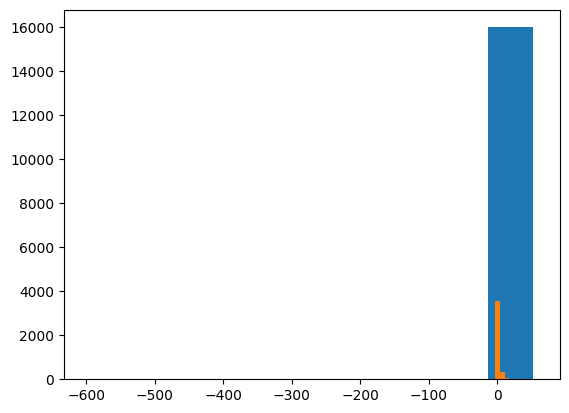

In [8]:
analyze_series(df_train.TargetPrice-df_train.BSAprox)
analyze_series(df_val.TargetPrice-df_val.BSAprox)

In [9]:
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_val) * np.sum((df_val.TargetPrice - df_val.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)

In [10]:
# import torch.multiprocessing as mp
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_val)
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    val_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7),
    "RMSprop": torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE),
    "Adam": torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
    "Adamax": torch.optim.Adamax(
        model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99)
    ),
}
criteriation = nn.MSELoss()

In [11]:
def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step(np.mean(train_losses))  # Step the scheduler based on training loss
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}"
        )

In [12]:
train_loss_dict = {}
val_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, val_loss_dict)

Optimizer: SGD


100%|██████████| 63/63 [00:00<00:00, 284.35it/s]

Epoch 1, train loss: 40.8450, test loss: 4.5599



100%|██████████| 63/63 [00:00<00:00, 257.17it/s]

Epoch 2, train loss: 41.1703, test loss: 5.2160



100%|██████████| 63/63 [00:00<00:00, 312.10it/s]

Epoch 3, train loss: 39.2786, test loss: 3.7161



100%|██████████| 63/63 [00:00<00:00, 194.41it/s]

Epoch 4, train loss: 38.3977, test loss: 3.2115



100%|██████████| 63/63 [00:00<00:00, 257.98it/s]

Epoch 5, train loss: 38.6879, test loss: 2.0460



100%|██████████| 63/63 [00:00<00:00, 300.62it/s]

Epoch 6, train loss: 38.4880, test loss: 2.4307



100%|██████████| 63/63 [00:00<00:00, 298.65it/s]

Epoch 7, train loss: 37.8980, test loss: 1.6531



100%|██████████| 63/63 [00:00<00:00, 293.11it/s]

Epoch 8, train loss: 37.4731, test loss: 2.2920



100%|██████████| 63/63 [00:00<00:00, 294.20it/s]

Epoch 9, train loss: 37.8962, test loss: 2.1194



100%|██████████| 63/63 [00:00<00:00, 306.07it/s]

Epoch 10, train loss: 37.6138, test loss: 2.5080



100%|██████████| 63/63 [00:00<00:00, 302.39it/s]

Epoch 11, train loss: 38.1549, test loss: 1.9946



100%|██████████| 63/63 [00:00<00:00, 311.19it/s]

Epoch 12, train loss: 39.7485, test loss: 8.6955



100%|██████████| 63/63 [00:00<00:00, 300.88it/s]

Epoch 13, train loss: 40.0116, test loss: 4.1182



100%|██████████| 250/250 [00:01<00:00, 157.72it/s]

Epoch 00014: reducing learning rate of group 0 to 5.0000e-05.



100%|██████████| 63/63 [00:00<00:00, 304.05it/s]

Epoch 14, train loss: 37.9563, test loss: 2.0890



100%|██████████| 63/63 [00:00<00:00, 303.76it/s]

Epoch 15, train loss: 36.0586, test loss: 1.3672



100%|██████████| 63/63 [00:00<00:00, 315.77it/s]

Epoch 16, train loss: 35.8050, test loss: 1.2060



100%|██████████| 63/63 [00:00<00:00, 293.99it/s]

Epoch 17, train loss: 35.6026, test loss: 1.0986



100%|██████████| 63/63 [00:00<00:00, 264.41it/s]

Epoch 18, train loss: 35.4528, test loss: 1.0679



100%|██████████| 63/63 [00:00<00:00, 290.54it/s]

Epoch 19, train loss: 35.3188, test loss: 1.1270



100%|██████████| 63/63 [00:00<00:00, 299.34it/s]

Epoch 20, train loss: 35.1544, test loss: 1.1794
Optimizer: RMSprop



100%|██████████| 63/63 [00:00<00:00, 333.89it/s]

Epoch 1, train loss: 37.4065, test loss: 1.3273



100%|██████████| 63/63 [00:00<00:00, 257.70it/s]

Epoch 2, train loss: 36.0973, test loss: 1.6485



100%|██████████| 63/63 [00:00<00:00, 252.61it/s]

Epoch 3, train loss: 36.1902, test loss: 2.7611



100%|██████████| 63/63 [00:00<00:00, 300.09it/s]

Epoch 4, train loss: 35.5342, test loss: 0.7323



100%|██████████| 63/63 [00:00<00:00, 294.46it/s]

Epoch 5, train loss: 35.0229, test loss: 0.9756



100%|██████████| 63/63 [00:00<00:00, 304.09it/s]

Epoch 6, train loss: 34.6230, test loss: 1.1073



100%|██████████| 63/63 [00:00<00:00, 263.63it/s]

Epoch 7, train loss: 34.2471, test loss: 0.6766



100%|██████████| 63/63 [00:00<00:00, 289.94it/s]

Epoch 8, train loss: 34.0366, test loss: 0.7087



100%|██████████| 63/63 [00:00<00:00, 304.89it/s]

Epoch 9, train loss: 35.0153, test loss: 0.9031



100%|██████████| 63/63 [00:00<00:00, 268.44it/s]

Epoch 10, train loss: 33.4628, test loss: 1.1323



100%|██████████| 63/63 [00:00<00:00, 319.50it/s]


Epoch 11, train loss: 33.8653, test loss: 0.7414


100%|██████████| 63/63 [00:00<00:00, 270.01it/s]

Epoch 12, train loss: 33.6074, test loss: 0.7184



100%|██████████| 63/63 [00:00<00:00, 317.87it/s]


Epoch 13, train loss: 33.6756, test loss: 0.9065


100%|██████████| 63/63 [00:00<00:00, 312.07it/s]

Epoch 14, train loss: 33.0694, test loss: 8.0292



100%|██████████| 63/63 [00:00<00:00, 305.02it/s]

Epoch 15, train loss: 32.7197, test loss: 1.2361



100%|██████████| 63/63 [00:00<00:00, 289.48it/s]

Epoch 16, train loss: 32.3570, test loss: 1.3978



100%|██████████| 63/63 [00:00<00:00, 303.42it/s]

Epoch 17, train loss: 31.8768, test loss: 1.2065



100%|██████████| 63/63 [00:00<00:00, 310.14it/s]

Epoch 18, train loss: 31.4156, test loss: 1.2019



100%|██████████| 63/63 [00:00<00:00, 288.79it/s]

Epoch 19, train loss: 33.0038, test loss: 0.5707



100%|██████████| 63/63 [00:00<00:00, 266.95it/s]

Epoch 20, train loss: 32.4256, test loss: 1.2053
Optimizer: Adam



100%|██████████| 63/63 [00:00<00:00, 282.89it/s]

Epoch 1, train loss: 32.1890, test loss: 0.6661



100%|██████████| 63/63 [00:00<00:00, 268.82it/s]

Epoch 2, train loss: 32.5951, test loss: 2.0238



100%|██████████| 63/63 [00:00<00:00, 307.27it/s]

Epoch 3, train loss: 32.2573, test loss: 0.9906



100%|██████████| 63/63 [00:00<00:00, 279.32it/s]

Epoch 4, train loss: 33.6144, test loss: 0.8661



100%|██████████| 63/63 [00:00<00:00, 270.61it/s]

Epoch 5, train loss: 33.1766, test loss: 0.8770



100%|██████████| 63/63 [00:00<00:00, 287.70it/s]

Epoch 6, train loss: 32.3649, test loss: 1.6237



100%|██████████| 250/250 [00:01<00:00, 133.50it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.



100%|██████████| 63/63 [00:00<00:00, 310.68it/s]

Epoch 7, train loss: 32.4453, test loss: 0.8206



100%|██████████| 63/63 [00:00<00:00, 289.91it/s]

Epoch 8, train loss: 29.9588, test loss: 0.6072



100%|██████████| 63/63 [00:00<00:00, 310.72it/s]

Epoch 9, train loss: 29.6241, test loss: 0.6346



100%|██████████| 63/63 [00:00<00:00, 279.02it/s]

Epoch 10, train loss: 29.3829, test loss: 0.8153



100%|██████████| 63/63 [00:00<00:00, 280.53it/s]

Epoch 11, train loss: 29.2606, test loss: 0.6659



100%|██████████| 63/63 [00:00<00:00, 291.78it/s]

Epoch 12, train loss: 29.0108, test loss: 0.5803



100%|██████████| 63/63 [00:00<00:00, 271.29it/s]

Epoch 13, train loss: 28.8905, test loss: 0.6917



100%|██████████| 63/63 [00:00<00:00, 294.06it/s]

Epoch 14, train loss: 28.7255, test loss: 0.5291



100%|██████████| 63/63 [00:00<00:00, 299.70it/s]

Epoch 15, train loss: 28.6254, test loss: 0.4729



100%|██████████| 63/63 [00:00<00:00, 315.28it/s]

Epoch 16, train loss: 28.5368, test loss: 0.4759



100%|██████████| 63/63 [00:00<00:00, 285.80it/s]

Epoch 17, train loss: 28.5097, test loss: 0.8145



100%|██████████| 63/63 [00:00<00:00, 305.12it/s]

Epoch 18, train loss: 28.2898, test loss: 0.5601



100%|██████████| 63/63 [00:00<00:00, 297.37it/s]

Epoch 19, train loss: 28.0565, test loss: 0.5509



100%|██████████| 63/63 [00:00<00:00, 241.52it/s]

Epoch 20, train loss: 27.9365, test loss: 0.5230
Optimizer: Adamax



100%|██████████| 63/63 [00:00<00:00, 297.50it/s]

Epoch 1, train loss: 30.6689, test loss: 0.5131



100%|██████████| 63/63 [00:00<00:00, 309.56it/s]

Epoch 2, train loss: 30.2855, test loss: 0.6034



100%|██████████| 63/63 [00:00<00:00, 309.40it/s]

Epoch 3, train loss: 30.4889, test loss: 0.5827



100%|██████████| 63/63 [00:00<00:00, 321.96it/s]

Epoch 4, train loss: 30.2434, test loss: 0.5937



100%|██████████| 63/63 [00:00<00:00, 300.85it/s]

Epoch 5, train loss: 30.0450, test loss: 0.5658



100%|██████████| 63/63 [00:00<00:00, 282.30it/s]

Epoch 6, train loss: 29.5825, test loss: 0.5765



100%|██████████| 63/63 [00:00<00:00, 282.48it/s]

Epoch 7, train loss: 29.4442, test loss: 0.5847



100%|██████████| 63/63 [00:00<00:00, 296.61it/s]

Epoch 8, train loss: 29.6498, test loss: 0.4951



100%|██████████| 63/63 [00:00<00:00, 297.09it/s]

Epoch 9, train loss: 28.9050, test loss: 0.5622



100%|██████████| 63/63 [00:00<00:00, 298.39it/s]

Epoch 10, train loss: 28.9005, test loss: 0.5401



100%|██████████| 63/63 [00:00<00:00, 300.20it/s]

Epoch 11, train loss: 29.0939, test loss: 0.6181



100%|██████████| 63/63 [00:00<00:00, 307.66it/s]

Epoch 12, train loss: 28.7736, test loss: 0.7068



100%|██████████| 63/63 [00:00<00:00, 330.90it/s]

Epoch 13, train loss: 28.5838, test loss: 0.7254



100%|██████████| 63/63 [00:00<00:00, 293.88it/s]

Epoch 14, train loss: 28.5049, test loss: 0.5648



100%|██████████| 63/63 [00:00<00:00, 319.95it/s]

Epoch 15, train loss: 29.4132, test loss: 0.5535



100%|██████████| 63/63 [00:00<00:00, 287.67it/s]

Epoch 16, train loss: 28.5759, test loss: 0.7037



100%|██████████| 63/63 [00:00<00:00, 299.51it/s]

Epoch 17, train loss: 28.3622, test loss: 0.6491



100%|██████████| 63/63 [00:00<00:00, 245.95it/s]

Epoch 18, train loss: 28.1818, test loss: 0.6464



100%|██████████| 63/63 [00:00<00:00, 252.61it/s]

Epoch 19, train loss: 29.4116, test loss: 0.6026



100%|██████████| 63/63 [00:00<00:00, 292.79it/s]

Epoch 20, train loss: 29.3393, test loss: 0.6129


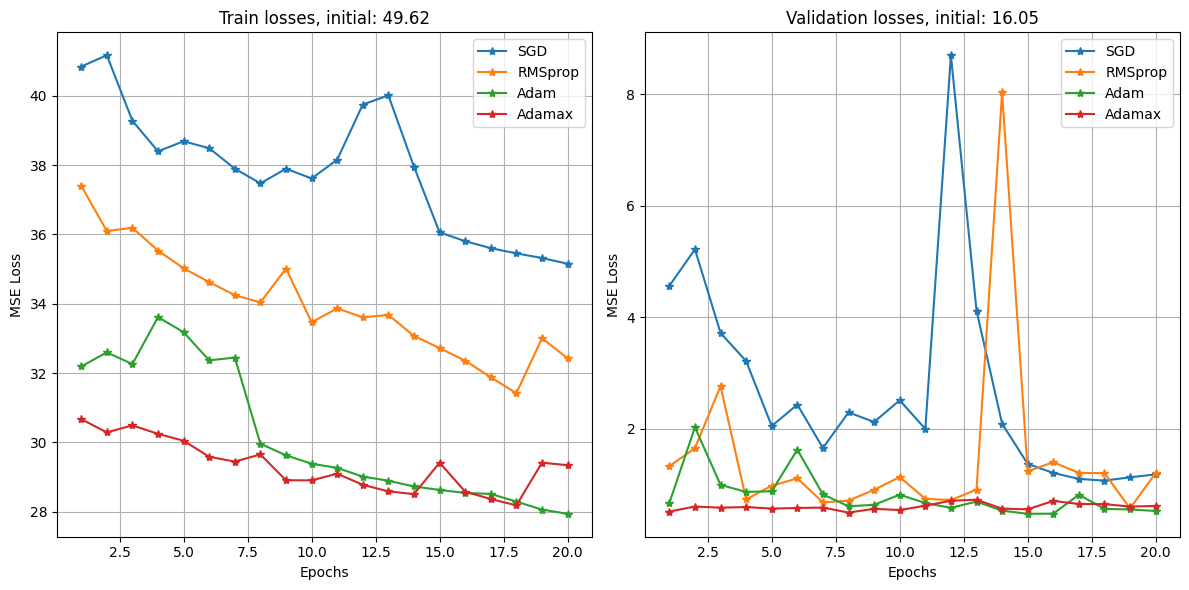

In [13]:
# Plot
plot_dictionaries(
    train_loss_dict,
    val_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_test.png",
)

### So for full training we will take Adam

In [16]:
# hyperparams for training
# df_real = pd.read_csv("../train_data/put_df_with_approx.csv", index_col=0)
N_EPOCH = 50
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 3e-5
HIDDEN_LAYER = 20
HIDDEN_WIDTH = 64
# EXPERIMENT_NAME = "exp_put_5_final"
# MODEL_TYPE = AmericanPut_gated3
# experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
# os.makedirs(experiment_dir, exist_ok=True)

In [33]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [17]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [18]:
df_real.shape

(223217, 12)

In [19]:
df_train, df_test = train_test_split(df_real, test_size=0.2)
logging.info(f"train set size: {df_train.shape}")
logging.info(f"test set size: {df_test.shape}")
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_test) * np.sum((df_test.TargetPrice - df_test.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)
train_df = CustomDataset(df_train)
test_df = CustomDataset(df_test)

In [20]:
def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step(np.mean(train_losses))  # Step the scheduler based on training loss
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}"
        )

In [21]:
# import torch.multiprocessing as mp
from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Set the multiprocessing start method to 'spawn'
# mp.set_start_method("spawn", force=True)
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    test_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "Adam": torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
    )
}
criteriation = nn.MSELoss()

In [23]:
train_loss_dict = {}
test_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, test_loss_dict, final=True)

Optimizer: Adam


100%|██████████| 698/698 [00:02<00:00, 331.13it/s]

Epoch 1, train loss: 22.3423, test loss: 20.2431



100%|██████████| 698/698 [00:01<00:00, 350.97it/s]

Epoch 2, train loss: 20.3822, test loss: 19.0278



100%|██████████| 698/698 [00:01<00:00, 358.69it/s]

Epoch 3, train loss: 19.5393, test loss: 18.3923



100%|██████████| 698/698 [00:01<00:00, 401.73it/s]

Epoch 4, train loss: 19.0675, test loss: 17.9573



100%|██████████| 698/698 [00:01<00:00, 359.23it/s]

Epoch 5, train loss: 18.7238, test loss: 17.5223



100%|██████████| 698/698 [00:01<00:00, 358.93it/s]

Epoch 6, train loss: 18.4007, test loss: 17.3194



100%|██████████| 698/698 [00:01<00:00, 353.71it/s]

Epoch 7, train loss: 18.0420, test loss: 17.5935



100%|██████████| 698/698 [00:02<00:00, 333.82it/s]

Epoch 8, train loss: 17.9100, test loss: 16.9120



100%|██████████| 698/698 [00:01<00:00, 367.65it/s]

Epoch 9, train loss: 17.9643, test loss: 16.6814



100%|██████████| 698/698 [00:02<00:00, 322.59it/s]

Epoch 10, train loss: 17.2125, test loss: 17.5797



100%|██████████| 698/698 [00:02<00:00, 311.03it/s]

Epoch 11, train loss: 17.6429, test loss: 16.8154



100%|██████████| 698/698 [00:01<00:00, 370.09it/s]

Epoch 12, train loss: 17.3213, test loss: 16.8322



100%|██████████| 698/698 [00:02<00:00, 342.86it/s]

Epoch 13, train loss: 16.8982, test loss: 16.8249



100%|██████████| 698/698 [00:01<00:00, 369.05it/s]

Epoch 14, train loss: 17.2255, test loss: 16.4145



100%|██████████| 698/698 [00:01<00:00, 366.92it/s]

Epoch 15, train loss: 17.1392, test loss: 16.1648



100%|██████████| 698/698 [00:01<00:00, 369.42it/s]

Epoch 16, train loss: 16.8020, test loss: 16.2120



100%|██████████| 698/698 [00:01<00:00, 365.27it/s]

Epoch 17, train loss: 16.7562, test loss: 16.4072



100%|██████████| 698/698 [00:02<00:00, 333.46it/s]

Epoch 18, train loss: 16.8565, test loss: 16.0336



100%|██████████| 698/698 [00:01<00:00, 372.72it/s]

Epoch 19, train loss: 16.7719, test loss: 16.1588



100%|██████████| 698/698 [00:01<00:00, 369.90it/s]

Epoch 20, train loss: 17.0668, test loss: 15.9096



100%|██████████| 698/698 [00:01<00:00, 369.52it/s]

Epoch 21, train loss: 16.4460, test loss: 15.5783



100%|██████████| 698/698 [00:01<00:00, 366.64it/s]

Epoch 22, train loss: 16.9028, test loss: 15.4761



100%|██████████| 698/698 [00:01<00:00, 372.28it/s]

Epoch 23, train loss: 16.1455, test loss: 15.5019



100%|██████████| 698/698 [00:01<00:00, 364.96it/s]

Epoch 24, train loss: 16.2177, test loss: 16.0900



100%|██████████| 698/698 [00:01<00:00, 366.32it/s]

Epoch 25, train loss: 16.3664, test loss: 15.4254



100%|██████████| 698/698 [00:01<00:00, 369.29it/s]

Epoch 26, train loss: 16.3619, test loss: 15.3842



100%|██████████| 698/698 [00:01<00:00, 364.07it/s]

Epoch 27, train loss: 16.0343, test loss: 15.3627



100%|██████████| 698/698 [00:02<00:00, 319.77it/s]


Epoch 28, train loss: 16.0865, test loss: 15.5361


100%|██████████| 698/698 [00:02<00:00, 348.22it/s]

Epoch 29, train loss: 16.1072, test loss: 15.5095



100%|██████████| 698/698 [00:01<00:00, 365.36it/s]

Epoch 30, train loss: 16.2381, test loss: 15.2528



100%|██████████| 698/698 [00:01<00:00, 387.31it/s]

Epoch 31, train loss: 16.1399, test loss: 15.4199



100%|██████████| 698/698 [00:01<00:00, 351.37it/s]

Epoch 32, train loss: 15.4527, test loss: 15.6282



100%|██████████| 698/698 [00:01<00:00, 358.61it/s]

Epoch 33, train loss: 15.4956, test loss: 15.5520



100%|██████████| 698/698 [00:02<00:00, 336.70it/s]

Epoch 34, train loss: 16.3660, test loss: 15.3385



100%|██████████| 698/698 [00:01<00:00, 360.92it/s]

Epoch 35, train loss: 15.9036, test loss: 15.4012



100%|██████████| 698/698 [00:02<00:00, 346.81it/s]

Epoch 36, train loss: 15.6979, test loss: 14.9687



100%|██████████| 698/698 [00:02<00:00, 348.91it/s]

Epoch 37, train loss: 15.2630, test loss: 15.1055



100%|██████████| 698/698 [00:02<00:00, 336.85it/s]

Epoch 38, train loss: 15.3546, test loss: 15.0375



100%|██████████| 698/698 [00:02<00:00, 343.80it/s]

Epoch 39, train loss: 15.2456, test loss: 14.9431



100%|██████████| 698/698 [00:02<00:00, 338.71it/s]


Epoch 40, train loss: 15.1682, test loss: 15.0036


100%|██████████| 698/698 [00:01<00:00, 371.35it/s]

Epoch 41, train loss: 15.0612, test loss: 15.2013



100%|██████████| 698/698 [00:01<00:00, 374.49it/s]

Epoch 42, train loss: 15.1895, test loss: 15.5060



100%|██████████| 698/698 [00:01<00:00, 385.00it/s]

Epoch 43, train loss: 15.9534, test loss: 14.9863



100%|██████████| 698/698 [00:01<00:00, 384.55it/s]

Epoch 44, train loss: 15.2731, test loss: 15.2904



100%|██████████| 698/698 [00:01<00:00, 385.06it/s]

Epoch 45, train loss: 15.7042, test loss: 15.3764



100%|██████████| 698/698 [00:01<00:00, 398.51it/s]


Epoch 46, train loss: 15.4423, test loss: 14.8872


100%|██████████| 698/698 [00:01<00:00, 427.66it/s]

Epoch 47, train loss: 14.9647, test loss: 15.1161



100%|██████████| 698/698 [00:01<00:00, 372.09it/s]


Epoch 48, train loss: 15.6693, test loss: 15.8845


100%|██████████| 698/698 [00:01<00:00, 438.59it/s]

Epoch 49, train loss: 15.9252, test loss: 14.8950



100%|██████████| 698/698 [00:01<00:00, 411.76it/s]

Epoch 50, train loss: 15.0459, test loss: 15.1703


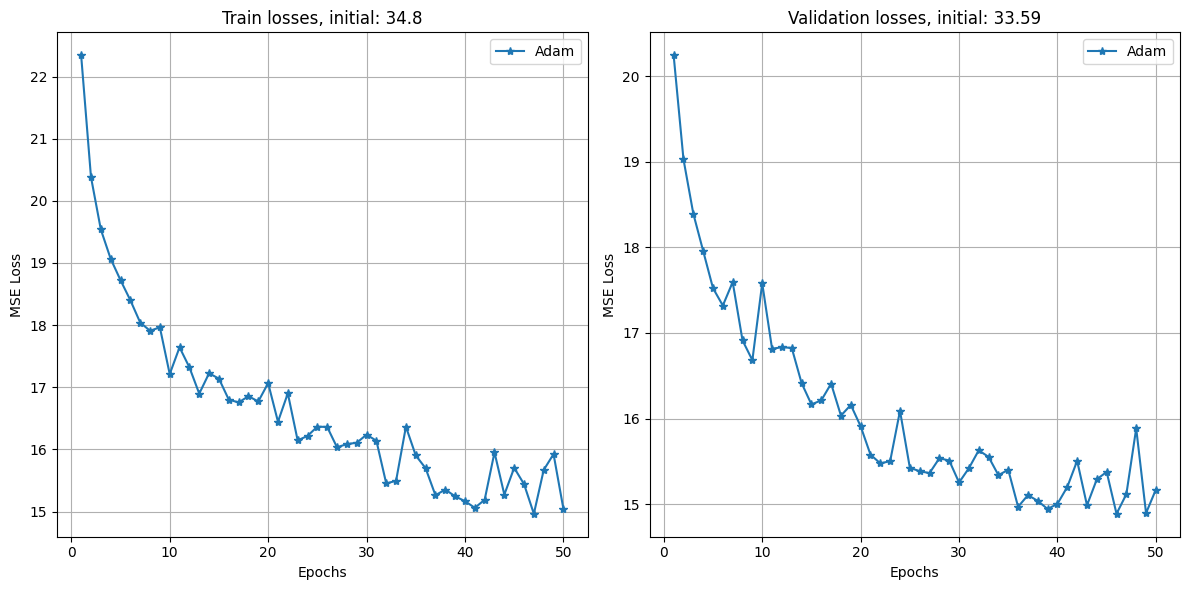

In [25]:
plot_dictionaries(
    train_loss_dict,
    test_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final.png",
)

In [26]:
import json

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "w") as json_file:
    json.dump(train_loss_dict, json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "w") as json_file:
    json.dump(test_loss_dict, json_file)

In [27]:
logging.info(
    f"% of variation before training: {(initial_mse_train/(df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(train_loss_dict['Adam'][46]/ (df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation before training: {(initial_mse_val/(df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(test_loss_dict['Adam'][46] / (df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)

In [29]:
def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step(np.mean(train_losses))  # Step the scheduler based on training loss
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    for i in range(N_EPOCH, 100):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}"
        )

In [30]:
train_loss_dict = {}
test_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, test_loss_dict, final=True)

Optimizer: Adam


100%|██████████| 698/698 [00:02<00:00, 346.55it/s]

Epoch 51, train loss: 15.1520, test loss: 15.0572



100%|██████████| 698/698 [00:02<00:00, 321.40it/s]

Epoch 52, train loss: 15.3887, test loss: 14.7960



100%|██████████| 698/698 [00:01<00:00, 350.77it/s]

Epoch 53, train loss: 15.1600, test loss: 15.0739



100%|██████████| 698/698 [00:01<00:00, 362.00it/s]

Epoch 54, train loss: 15.5402, test loss: 14.8740



100%|██████████| 698/698 [00:01<00:00, 357.46it/s]

Epoch 55, train loss: 15.3245, test loss: 14.9195



100%|██████████| 698/698 [00:01<00:00, 368.30it/s]

Epoch 56, train loss: 14.5784, test loss: 15.5519



100%|██████████| 698/698 [00:01<00:00, 362.18it/s]

Epoch 57, train loss: 14.6905, test loss: 15.2107



100%|██████████| 698/698 [00:01<00:00, 363.73it/s]

Epoch 58, train loss: 14.7698, test loss: 15.0287



100%|██████████| 698/698 [00:01<00:00, 366.32it/s]

Epoch 59, train loss: 14.6966, test loss: 14.9380



100%|██████████| 698/698 [00:01<00:00, 360.32it/s]

Epoch 60, train loss: 14.7310, test loss: 14.8965



100%|██████████| 698/698 [00:01<00:00, 367.51it/s]

Epoch 61, train loss: 15.1140, test loss: 14.9883



100%|██████████| 2791/2791 [00:20<00:00, 133.78it/s]

Epoch 00012: reducing learning rate of group 0 to 3.0000e-06.



100%|██████████| 698/698 [00:02<00:00, 348.21it/s]

Epoch 62, train loss: 15.0032, test loss: 15.0009



100%|██████████| 698/698 [00:02<00:00, 333.69it/s]


Epoch 63, train loss: 13.9765, test loss: 14.9068


100%|██████████| 698/698 [00:01<00:00, 383.90it/s]

Epoch 64, train loss: 13.9467, test loss: 14.8981



100%|██████████| 698/698 [00:01<00:00, 386.41it/s]

Epoch 65, train loss: 13.9420, test loss: 14.8892



100%|██████████| 698/698 [00:01<00:00, 385.55it/s]

Epoch 66, train loss: 13.9126, test loss: 14.8817



100%|██████████| 698/698 [00:01<00:00, 383.74it/s]

Epoch 67, train loss: 13.9087, test loss: 14.8849



100%|██████████| 698/698 [00:01<00:00, 386.19it/s]

Epoch 68, train loss: 13.8657, test loss: 14.8844



100%|██████████| 698/698 [00:01<00:00, 381.88it/s]

Epoch 69, train loss: 13.8717, test loss: 14.8792



100%|██████████| 698/698 [00:01<00:00, 382.20it/s]

Epoch 70, train loss: 13.8497, test loss: 14.8795



100%|██████████| 698/698 [00:01<00:00, 376.96it/s]


Epoch 71, train loss: 13.8242, test loss: 14.8854


100%|██████████| 698/698 [00:01<00:00, 352.94it/s]

Epoch 72, train loss: 13.8136, test loss: 14.9072



100%|██████████| 698/698 [00:02<00:00, 341.90it/s]

Epoch 73, train loss: 13.8525, test loss: 14.8810



100%|██████████| 698/698 [00:02<00:00, 342.65it/s]

Epoch 74, train loss: 13.7920, test loss: 14.8710



100%|██████████| 698/698 [00:01<00:00, 356.31it/s]

Epoch 75, train loss: 13.8038, test loss: 14.8800



100%|██████████| 698/698 [00:01<00:00, 395.53it/s]

Epoch 76, train loss: 13.7929, test loss: 14.8801



100%|██████████| 698/698 [00:01<00:00, 409.48it/s]

Epoch 77, train loss: 13.7795, test loss: 14.8827



100%|██████████| 698/698 [00:01<00:00, 355.67it/s]

Epoch 78, train loss: 13.7519, test loss: 14.9581



100%|██████████| 698/698 [00:01<00:00, 358.27it/s]

Epoch 79, train loss: 13.7587, test loss: 14.8782



100%|██████████| 698/698 [00:02<00:00, 341.55it/s]

Epoch 80, train loss: 13.7785, test loss: 14.9013



100%|██████████| 698/698 [00:01<00:00, 353.28it/s]

Epoch 81, train loss: 13.7422, test loss: 14.8886



100%|██████████| 698/698 [00:01<00:00, 397.55it/s]

Epoch 82, train loss: 13.7631, test loss: 14.8928



100%|██████████| 698/698 [00:02<00:00, 336.77it/s]

Epoch 83, train loss: 13.7549, test loss: 14.8892



100%|██████████| 698/698 [00:01<00:00, 367.69it/s]

Epoch 84, train loss: 13.7512, test loss: 14.8932



100%|██████████| 698/698 [00:01<00:00, 352.76it/s]

Epoch 85, train loss: 13.7179, test loss: 14.8955



100%|██████████| 698/698 [00:01<00:00, 364.66it/s]

Epoch 86, train loss: 13.7321, test loss: 14.9013



100%|██████████| 698/698 [00:01<00:00, 359.67it/s]


Epoch 87, train loss: 13.7366, test loss: 14.8958


100%|██████████| 698/698 [00:01<00:00, 363.28it/s]

Epoch 88, train loss: 13.6819, test loss: 14.9143



100%|██████████| 698/698 [00:01<00:00, 379.32it/s]

Epoch 89, train loss: 13.6712, test loss: 14.9184



100%|██████████| 698/698 [00:01<00:00, 400.47it/s]

Epoch 90, train loss: 13.7265, test loss: 14.9111



100%|██████████| 698/698 [00:01<00:00, 424.63it/s]

Epoch 91, train loss: 13.6992, test loss: 14.9058



100%|██████████| 698/698 [00:01<00:00, 376.12it/s]

Epoch 92, train loss: 13.7273, test loss: 14.9105



100%|██████████| 698/698 [00:01<00:00, 371.47it/s]

Epoch 93, train loss: 13.6984, test loss: 14.9097



100%|██████████| 698/698 [00:01<00:00, 377.15it/s]


Epoch 94, train loss: 13.6989, test loss: 14.9163


100%|██████████| 2791/2791 [00:20<00:00, 137.37it/s]

Epoch 00045: reducing learning rate of group 0 to 3.0000e-07.



100%|██████████| 698/698 [00:01<00:00, 349.47it/s]

Epoch 95, train loss: 13.7266, test loss: 14.9154



100%|██████████| 698/698 [00:01<00:00, 353.70it/s]

Epoch 96, train loss: 13.5943, test loss: 14.9160



100%|██████████| 698/698 [00:01<00:00, 388.76it/s]

Epoch 97, train loss: 13.5934, test loss: 14.9140



100%|██████████| 698/698 [00:01<00:00, 378.01it/s]

Epoch 98, train loss: 13.5931, test loss: 14.9152



100%|██████████| 698/698 [00:01<00:00, 369.65it/s]

Epoch 99, train loss: 13.5932, test loss: 14.9155



100%|██████████| 698/698 [00:01<00:00, 377.52it/s]

Epoch 100, train loss: 13.5906, test loss: 14.9126


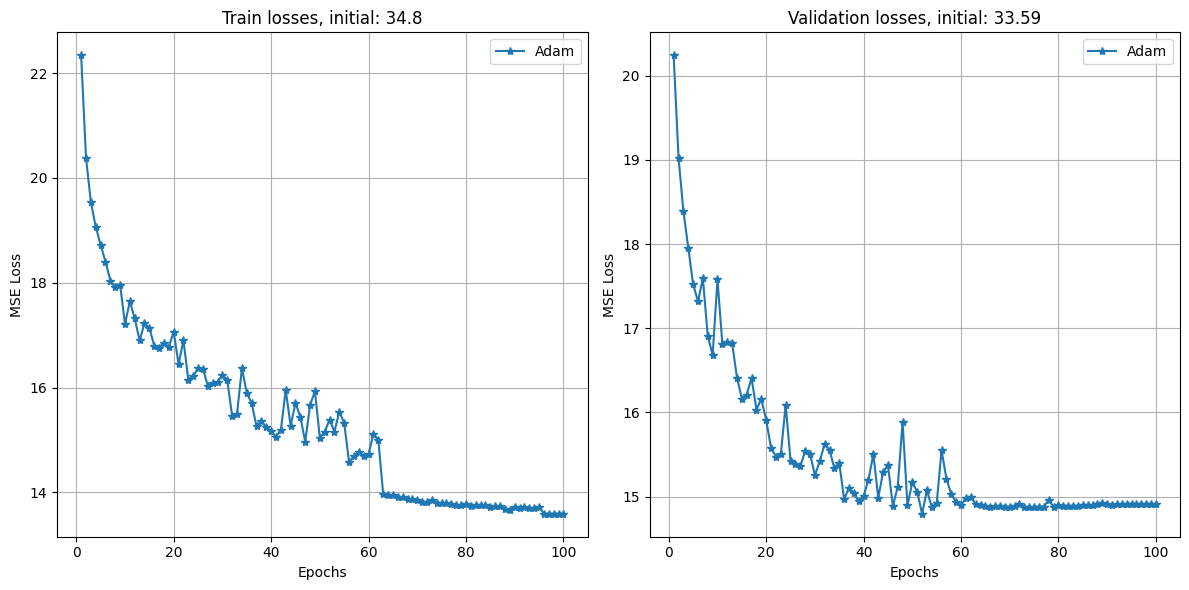

In [45]:
file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "r") as json_file:
    first_50_train = json.load(json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "r") as json_file:
    first_50_test = json.load(json_file)

train = np.concatenate((first_50_train["Adam"], train_loss_dict["Adam"]))
test = np.concatenate((first_50_test["Adam"], test_loss_dict["Adam"]))
train_all = {"Adam":train}
test_all = {"Adam":test}
plot_dictionaries(
    train_all,
    test_all,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final.png",
)

In [49]:
print(
    f"% of variation before training: {(initial_mse_train*100/(df_train.TargetPrice - df_train.BSAprox).var()).round(2)}"
)
print(
    f"% of variation after training: {(train_all['Adam'][60]*100/ (df_train.TargetPrice - df_train.BSAprox).var()).round(2)}"
)
print(
    f"% of variation before training: {(initial_mse_val*100/(df_test.TargetPrice - df_test.BSAprox).var()).round(2)}"
)
print(
    f"% of variation after training: {(train_all['Adam'][60]*100 / (df_test.TargetPrice - df_test.BSAprox).var()).round(2)}"
)

% of variation before training: 108.54
% of variation after training: 47.15
% of variation before training: 108.57
% of variation after training: 48.85
